## Introduction
Greetings from the Kaggle bot! This is an automatically-generated kernel with starter code demonstrating how to read in the data and begin exploring. If you're inspired to dig deeper, click the blue "Fork Notebook" button at the top of this kernel to begin editing.

## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions for plotting the data using `matplotlib`. Depending on the data, not all plots will be made. (Hey, I'm just a simple kerneling bot, not a Kaggle Competitions Grandmaster!)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


There is 0 csv file in the current version of the dataset:


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sapienza-university-mobile-palmprint-databasesmpd/Sapienza University Mobile Palmprint Database(SMPD)/057/057_F_8.JPG
/kaggle/input/sapienza-university-mobile-palmprint-databasesmpd/Sapienza University Mobile Palmprint Database(SMPD)/057/057_F_2.JPG
/kaggle/input/sapienza-university-mobile-palmprint-databasesmpd/Sapienza University Mobile Palmprint Database(SMPD)/057/057_F_4.JPG
/kaggle/input/sapienza-university-mobile-palmprint-databasesmpd/Sapienza University Mobile Palmprint Database(SMPD)/057/057_P_27.JPG
/kaggle/input/sapienza-university-mobile-palmprint-databasesmpd/Sapienza University Mobile Palmprint Database(SMPD)/057/057_RP_37.JPG
/kaggle/input/sapienza-university-mobile-palmprint-databasesmpd/Sapienza University Mobile Palmprint Database(SMPD)/057/057_RF_19.JPG
/kaggle/input/sapienza-university-mobile-palmprint-databasesmpd/Sapienza University Mobile Palmprint Database(SMPD)/057/057_P_23.JPG
/kaggle/input/sapienza-university-mobile-palmprint-databasesmpd/Sapien

In [3]:
# len(os.listdir('/kaggle/input/sapienza university mobile palmprint database(smpd)/Sapienza University Mobile Palmprint Database(SMPD)'))
!ls '/kaggle/input/tongji-palmprint/Tongji_Contactless_Palmprint_Dataset'

0001  0009  0017  0025	0033  0041  0049  0057	0065  0073  0081  0089	0097
0002  0010  0018  0026	0034  0042  0050  0058	0066  0074  0082  0090	0098
0003  0011  0019  0027	0035  0043  0051  0059	0067  0075  0083  0091	0099
0004  0012  0020  0028	0036  0044  0052  0060	0068  0076  0084  0092	0100
0005  0013  0021  0029	0037  0045  0053  0061	0069  0077  0085  0093
0006  0014  0022  0030	0038  0046  0054  0062	0070  0078  0086  0094
0007  0015  0023  0031	0039  0047  0055  0063	0071  0079  0087  0095
0008  0016  0024  0032	0040  0048  0056  0064	0072  0080  0088  0096


In [4]:

# Selects top view images from the Sapienza University Mobile Palmprint Database:SMPD,
# applies a noise filter and processes them to have the same orientation.
# https://www.kaggle.com/datasets/mahdieizadpanah/sapienza-university-mobile-palmprint-databasesmpd

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
from scipy.signal import filtfilt, butter, find_peaks


def rotateImg(img, angle):
    center = tuple(np.array(img.shape[1::-1]) / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply the rotation matrix to the input image
    rotated = cv2.warpAffine(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return rotated


def plotTwoCurves(x, y1, y2):
    fig, ax = plt.subplots()
    ax.plot(x, y1, color='red', label='top')

    # Plot the second curve (in red) on the same axis
    ax.plot(x, y2, color='blue', label='bottom')

    # Set the axis labels and title
    ax.set_xlabel('x (pixel pos''n)')
    ax.set_ylabel('intensity')
    ax.set_title('top & bottom image intensity')
    # Add a legend to the plot
    ax.legend()
    # Display the plot
    plt.show()

raw_data_folder = '/kaggle/input/tongji-palmprint/Tongji_Contactless_Palmprint_Dataset'    # folder with image inputs
processed_folder = '/kaggle/working/selected_palmprints'    # folder with image outputs

#fiter_coeffs
f_b, f_a = butter(2, 1/10, btype='lowpass', analog=False)

if os.path.isdir(processed_folder) is False:
    os.makedirs(processed_folder)
    for folder in glob.glob(os.path.join(raw_data_folder, '*')):
        if os.path.isdir(folder):
            delimiter = '/'
            substrs = folder.split(delimiter)
            folderName = substrs[-1]
            #if folderName != '044':     #in case you want to work on a specific class
            #    continue
            for file in glob.glob(os.path.join(folder, '*')):
                if os.path.isfile(file):  #only process top view images
                    print('Processing file '+file)
                    delimiter = '/'
                    substrs = file.split(delimiter)
                    fileName = substrs[-1]
                    img = cv2.imread(file)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.medianBlur(img, 5)  # median filter image
                    [ln, wd, _] = img.shape
                    #make sure the images all have the same alignment
                    if wd > ln:
                        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                        [ln, wd, _] = img.shape
                    gr_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                    rd_img = img[:,:,1]

                    # check the intensity of top and bottom parts of the image
                    topStrip = rd_img[1:ln//55, :]
                    topStrip = np.mean(topStrip, axis=0)/255
                    bottomStrip = rd_img[54*ln//55:, :]
                    bottomStrip = np.mean(bottomStrip, axis=0)/255

                    topStrip = filtfilt(f_b, f_a, topStrip)
                    bottomStrip = filtfilt(f_b, f_a, bottomStrip)

                    # count the number of peaks. Fingers generate multiple peaks and wrist generates a single peak
                    minTop = np.min(topStrip)
                    maxTop = np.max(topStrip)
                    minBottom = np.min(bottomStrip)
                    maxBottom = np.max(bottomStrip)
                    diffTop = maxTop-minTop
                    diffBottom = maxBottom-minBottom
                    avgDiff = diffTop/2 + diffBottom/2
                    topStrip = np.pad(topStrip, (1, 1), mode='constant', constant_values=minTop)
                    bottomStrip = np.pad(bottomStrip, (1, 1), mode='constant', constant_values=minBottom)

                    count = 0
                    peaksTop = np.array([0])
                    peaksBottom = np.array([0])

                    #plotTwoCurves(range(wd+2), topStrip-np.mean(topStrip), bottomStrip-np.mean(bottomStrip))

                    # make sure the fingers are on top. If not rotate image
                    while count < 3 and  len(peaksTop) == len(peaksBottom):
                        peaksTop, _ = find_peaks(topStrip, prominence=avgDiff/(3+count), distance=wd//9, width=wd//20)
                        peaksBottom, _ = find_peaks(bottomStrip, prominence=avgDiff / (3+count), distance=wd//9, width=wd//20)
                        if len(peaksTop) < len(peaksBottom):
                            img = cv2.rotate(img, cv2.ROTATE_180)
                            break
                        count += 1

                    if len(peaksTop) == len(peaksBottom):
                        darkBottom = bottomStrip < diffBottom*0.1 + minBottom
                        darkTop = topStrip < diffTop*0.1 + minTop
                        if np.count_nonzero(darkBottom) < np.count_nonzero(darkTop):
                            img = cv2.rotate(img, cv2.ROTATE_180)

                    # save processed image
                    savePath = processed_folder + '/' + folderName + '/'
                    print(savePath)
                    if os.path.isdir(savePath) is False:
                        os.makedirs(savePath)
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(savePath + fileName, img)
                    print("Saved " + savePath + fileName)

Processing file /kaggle/input/tongji-palmprint/Tongji_Contactless_Palmprint_Dataset/0035/0035_0001.bmp
/kaggle/working/selected_palmprints/0035/
Saved /kaggle/working/selected_palmprints/0035/0035_0001.bmp
Processing file /kaggle/input/tongji-palmprint/Tongji_Contactless_Palmprint_Dataset/0035/0035_0002.bmp
/kaggle/working/selected_palmprints/0035/
Saved /kaggle/working/selected_palmprints/0035/0035_0002.bmp
Processing file /kaggle/input/tongji-palmprint/Tongji_Contactless_Palmprint_Dataset/0035/0035_0009.bmp
/kaggle/working/selected_palmprints/0035/
Saved /kaggle/working/selected_palmprints/0035/0035_0009.bmp
Processing file /kaggle/input/tongji-palmprint/Tongji_Contactless_Palmprint_Dataset/0035/0035_0010.bmp
/kaggle/working/selected_palmprints/0035/
Saved /kaggle/working/selected_palmprints/0035/0035_0010.bmp
Processing file /kaggle/input/tongji-palmprint/Tongji_Contactless_Palmprint_Dataset/0035/0035_0007.bmp
/kaggle/working/selected_palmprints/0035/
Saved /kaggle/working/selected_

In [5]:


# Applied data augmentation and downsampling to the Sapienza University Mobile Palmprint Database:SMPD,
# Increases the number of images, downsamples and standardizes the size of images.
# https://www.kaggle.com/datasets/mahdieizadpanah/sapienza-university-mobile-palmprint-databasesmpd

import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
# augment data and save in a standard size for all images

def plotImages(images_arr, numImages):
    fig, axes = plt.subplots(1,numImages, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def resizeImage(filepath):
    output_ln = 408
    output_wd = 306
    
    image = Image.open(filepath)
    image_resized = image.resize((output_wd, output_ln), Image.LANCZOS)
    image_resized.save(filepath)
    


processed_folder = '/kaggle/working/selected_palmprints'   # folder with image inputs
augmented_folder = '/kaggle/working/augmented_palmprints'   # folder with image outputs

gen = ImageDataGenerator(rotation_range=5, width_shift_range=0.01, height_shift_range=0.01, shear_range=0.12, zoom_range=0.06, channel_shift_range=10, horizontal_flip=False)
numExtraImages = 3

if os.path.isdir(augmented_folder) is False:
    os.makedirs(augmented_folder, exist_ok=True)
for folder in glob.glob(os.path.join(processed_folder, '*')):
    if os.path.isdir(folder):
        delimiter = '/'
        substrs = folder.split(delimiter)
        folderName = substrs[-1]
        for file in glob.glob(os.path.join(folder, '*')):
            if os.path.isfile(file):
                print('Processing file ' + file)
                delimiter = '/'
                substrs = file.split(delimiter)
                fileName = substrs[-1]
                assert os.path.isfile(file)
                resizeImage(file)
                img = cv2.imread(file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                image = np.expand_dims(img, 0)
                # plot original image
                #plt.imshow(image[0])

                aug_iter = gen.flow(image)
                aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(numExtraImages)]
                # plot augmented images
                #plotImages(aug_images, numExtraImages)

                fileModified = fileName[:9] + '0' + fileName[9:]
                if os.path.isdir(augmented_folder+'/'+folderName) is False:
                    os.makedirs(augmented_folder+'/'+folderName)

                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                cv2.imwrite(augmented_folder + '/' + folderName + '/' + fileModified, img)

                for k in range(1, np.min([numExtraImages+1, 10])):
                    fileModified = fileName[:9]+chr(k+48)+fileName[9:]
                    img = cv2.cvtColor(aug_images[k-1], cv2.COLOR_RGB2BGR)
                    cv2.imwrite(augmented_folder+'/'+folderName+'/'+fileModified, img)

Processing file /kaggle/working/selected_palmprints/0059/0059_0003.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0002.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0008.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0007.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0001.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0006.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0009.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0005.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0010.bmp
Processing file /kaggle/working/selected_palmprints/0059/0059_0004.bmp
Processing file /kaggle/working/selected_palmprints/0058/0058_0001.bmp
Processing file /kaggle/working/selected_palmprints/0058/0058_0003.bmp
Processing file /kaggle/working/selected_palmprints/0058/0058_0004.bmp
Processing file /kaggle/working/selected_palmprints/0058/0058_0002.bmp
Proces

In [6]:
len(os.listdir('/kaggle/working/augmented_palmprints'))
!ls '/kaggle/working/augmented_palmprints/0001'
cv2.imread('/kaggle/working/augmented_palmprints/0001/0001_00010.bmp').shape

0001_00010.bmp	0001_00030.bmp	0001_00050.bmp	0001_00070.bmp	0001_00090.bmp
0001_00011.bmp	0001_00031.bmp	0001_00051.bmp	0001_00071.bmp	0001_00091.bmp
0001_00012.bmp	0001_00032.bmp	0001_00052.bmp	0001_00072.bmp	0001_00092.bmp
0001_00013.bmp	0001_00033.bmp	0001_00053.bmp	0001_00073.bmp	0001_00093.bmp
0001_00020.bmp	0001_00040.bmp	0001_00060.bmp	0001_00080.bmp	0001_00100.bmp
0001_00021.bmp	0001_00041.bmp	0001_00061.bmp	0001_00081.bmp	0001_00101.bmp
0001_00022.bmp	0001_00042.bmp	0001_00062.bmp	0001_00082.bmp	0001_00102.bmp
0001_00023.bmp	0001_00043.bmp	0001_00063.bmp	0001_00083.bmp	0001_00103.bmp


(408, 306, 3)

In [7]:

# Forms the train, validation and test sets from pre-processed palm images
# For each subject with palm prints the code selects one palm image as template to match
# it then generates 30 matching and 30 non-matching training pairs using the template and a random sample,
# 6 matching and 6 non-matching validation pairs and 3 matching, 3 non-matching test pairs.
# Overall 2760 positive 2760 negative training, 552 positive, 552 negative validation,
# 276 positive and 276 negative test data are generated.

import os
import random
import shutil

input_dir = '/kaggle/working/augmented_palmprints'

# Set up directories
train_dir1 = '/kaggle/working/trainTestVal/train/1'
val_dir1 = '/kaggle/working/trainTestVal/validation/1'
test_dir1 = '/kaggle/working/trainTestVal/test/1'

train_dir0 = '/kaggle/working/trainTestVal/train/0'
val_dir0 = '/kaggle/working/trainTestVal/validation/0'
test_dir0 = '/kaggle/working/trainTestVal/test/0'

train_dir_t = '/kaggle/working/trainTestVal/train/t'
val_dir_t = '/kaggle/working/trainTestVal/validation/t'
test_dir_t = '/kaggle/working/trainTestVal/test/t'
num_train = 28
num_val = 5
num_test = 3

if not os.path.exists(train_dir1):
    os.makedirs(train_dir1)
if not os.path.exists(val_dir1):
    os.makedirs(val_dir1)
if not os.path.exists(test_dir1):
    os.makedirs(test_dir1)
if not os.path.exists(train_dir0):
    os.makedirs(train_dir0)
if not os.path.exists(val_dir0):
    os.makedirs(val_dir0)
if not os.path.exists(test_dir0):
    os.makedirs(test_dir0)
if not os.path.exists(train_dir_t):
    os.makedirs(train_dir_t)
if not os.path.exists(val_dir_t):
    os.makedirs(val_dir_t)
if not os.path.exists(test_dir_t):
    os.makedirs(test_dir_t)

train_file_index = 0
val_file_index = 0
test_file_index = 0


for class_folder in os.listdir(input_dir):
    print('processing folder: '+class_folder)
    class_path = os.path.join(input_dir, class_folder)
    if os.path.isdir(class_path):
        # Get list of image files
        img_files = os.listdir(class_path)
        if len(img_files) < 35: continue
        template_file = [f for f in img_files if f.lower().endswith('0.bmp')][0]
        # Remove template image
        img_files.remove(template_file)
        # Randomly select 30 images for training
        train_imgs_p = random.sample(img_files, num_train)
        # Randomly select 6 images for validation
        val_imgs_p = random.sample(list(set(img_files) - set(train_imgs_p)), num_val)
        # Use remaining 3 images for testing
        test_imgs_p = list(set(img_files) - set(train_imgs_p) - set(val_imgs_p))

        other_classes = [c for c in os.listdir(input_dir) if c != class_folder]
        img_files = []
        for folder in other_classes:
            img_list = os.listdir(os.path.join(input_dir, folder))
            img_list_w_path = [os.path.join(input_dir,folder, img) for img in img_list]
            img_files.extend(img_list_w_path)

        # Randomly select 30 images for training
        train_imgs_n = random.sample(img_files, num_train)
        # Randomly select 6 images for validation
        val_imgs_n = random.sample(list(set(img_files) - set(train_imgs_n)), num_val)
        # Use remaining 3 images for testing
        test_imgs_n = random.sample(list(set(img_files) - set(train_imgs_n) - set(val_imgs_n)), num_test)

        # Create pairs for training
        for img_file_p, img_file_n in zip(train_imgs_p, train_imgs_n):
            # Create a unique index for each pair
            train_file_index += 1
            copiedName = f'img{train_file_index:04d}.bmp'
            # Copy template file
            shutil.copy(os.path.join(class_path, template_file), os.path.join(train_dir_t, copiedName))
            # Copy positive sample
            shutil.copy(os.path.join(class_path, img_file_p), os.path.join(train_dir1, copiedName))
            # Copy negative sample
            shutil.copy(os.path.join(class_path, img_file_n), os.path.join(train_dir0, copiedName))

        # Create pairs for validation
        for img_file_p, img_file_n in zip(val_imgs_p, val_imgs_n):
            # Create a unique index for each pair
            val_file_index += 1
            copiedName = f'img{val_file_index:04d}.bmp'
            # Copy template file
            shutil.copy(os.path.join(class_path, template_file), os.path.join(val_dir_t, copiedName))
            # Copy positive sample
            shutil.copy(os.path.join(class_path, img_file_p), os.path.join(val_dir1, copiedName))
            # Copy negative sample
            shutil.copy(os.path.join(class_path, img_file_n), os.path.join(val_dir0, copiedName))

        # Create pairs for testing
        for img_file_p, img_file_n in zip(test_imgs_p, test_imgs_n):
            # Create a unique index for each pair
            test_file_index += 1
            copiedName = f'img{test_file_index:04d}.bmp'
            # Copy template file
            shutil.copy(os.path.join(class_path, template_file), os.path.join(test_dir_t, copiedName))
            # Copy positive sample
            shutil.copy(os.path.join(class_path, img_file_p), os.path.join(test_dir1, copiedName))
            # Copy negative sample
            shutil.copy(os.path.join(class_path, img_file_n), os.path.join(test_dir0, copiedName))

processing folder: 0059
processing folder: 0058
processing folder: 0068
processing folder: 0097
processing folder: 0061
processing folder: 0073
processing folder: 0091
processing folder: 0066
processing folder: 0070
processing folder: 0098
processing folder: 0069
processing folder: 0044
processing folder: 0019
processing folder: 0084
processing folder: 0038
processing folder: 0085
processing folder: 0094
processing folder: 0033
processing folder: 0021
processing folder: 0050
processing folder: 0027
processing folder: 0100
processing folder: 0075
processing folder: 0008
processing folder: 0071
processing folder: 0030
processing folder: 0035
processing folder: 0072
processing folder: 0025
processing folder: 0090
processing folder: 0067
processing folder: 0082
processing folder: 0022
processing folder: 0047
processing folder: 0093
processing folder: 0076
processing folder: 0054
processing folder: 0040
processing folder: 0051
processing folder: 0004
processing folder: 0007
processing folde

In [8]:
!ls /kaggle/input/iitd-traintestval/content/drive/MyDrive/trainTestVal/train/1

img0001.jpg  img0377.jpg  img0753.jpg  img1129.jpg  img1505.jpg  img1881.jpg
img0002.jpg  img0378.jpg  img0754.jpg  img1130.jpg  img1506.jpg  img1882.jpg
img0003.jpg  img0379.jpg  img0755.jpg  img1131.jpg  img1507.jpg  img1883.jpg
img0004.jpg  img0380.jpg  img0756.jpg  img1132.jpg  img1508.jpg  img1884.jpg
img0005.jpg  img0381.jpg  img0757.jpg  img1133.jpg  img1509.jpg  img1885.jpg
img0006.jpg  img0382.jpg  img0758.jpg  img1134.jpg  img1510.jpg  img1886.jpg
img0007.jpg  img0383.jpg  img0759.jpg  img1135.jpg  img1511.jpg  img1887.jpg
img0008.jpg  img0384.jpg  img0760.jpg  img1136.jpg  img1512.jpg  img1888.jpg
img0009.jpg  img0385.jpg  img0761.jpg  img1137.jpg  img1513.jpg  img1889.jpg
img0010.jpg  img0386.jpg  img0762.jpg  img1138.jpg  img1514.jpg  img1890.jpg
img0011.jpg  img0387.jpg  img0763.jpg  img1139.jpg  img1515.jpg  img1891.jpg
img0012.jpg  img0388.jpg  img0764.jpg  img1140.jpg  img1516.jpg  img1892.jpg
img0013.jpg  img0389.jpg  img0765.jpg  img1141.jpg  img1517.jpg  img1893.jpg

Get Mean RGB values and save to CSV

In [9]:

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# get mean rgb values from all processed training images

train_dir1 = '/kaggle/working/trainTestVal/train/1'
img_files = os.listdir(train_dir1)

r_sum = g_sum = b_sum = 0
for file in tqdm(img_files):
    img = cv2.imread(os.path.join(train_dir1, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r_sum += np.sum(img[:, :, 0])/255
    g_sum += np.sum(img[:, :, 1])/255
    b_sum += np.sum(img[:, :, 2])/255

[img_sz_y, img_sz_x, _] = img.shape
r_avg = r_sum/(len(img_files)*img_sz_y*img_sz_x)
g_avg = g_sum/(len(img_files)*img_sz_y*img_sz_x)
b_avg = b_sum/(len(img_files)*img_sz_y*img_sz_x)

rgb_dict = { 'r': [r_avg], 'g': [g_avg], 'b':[b_avg]}

df = pd.DataFrame(rgb_dict)
df.to_csv('mean_rgb_val.csv', index=False)

100%|██████████| 2212/2212 [00:02<00:00, 985.06it/s]


****Model Training****

In [10]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input, Lambda, concatenate, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import os
import random
import numpy as np


M = 408
N = 306

batch_sz = 16
num_epochs = 48

train_path = '/kaggle/working/trainTestVal/train/'
val_path = '/kaggle/working/trainTestVal/validation'
test_path = '/kaggle/working/trainTestVal/test'
classNames = ['no_match', 'match']

tf.compat.v1.disable_eager_execution()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
#             physical_gpus = tf.config.list_physical_gpus('GPU')
#             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# generates pairs of template + matching image and template + non-matching image
def generate_pairs(directory, shuffle=True):
    template_folder = os.path.join(directory, 't')
    pos_folder = os.path.join(directory, '1')
    neg_folder = os.path.join(directory, '0')

    num_images = len(os.listdir(template_folder))

    # Generate positive pairs
    pos_pairs = []
    template_idx = 0
    for i in range(num_images):
        template_idx += 1
        pos_idx = template_idx  # Use the same index for template and positive image
        template_file = os.path.join(template_folder, 'img{:04d}.bmp'.format(template_idx))
        pos_file = os.path.join(pos_folder, 'img{:04d}.bmp'.format(pos_idx))
        pos_pairs.append([template_file, pos_file, 1])
    # Generate negative pairs
    neg_pairs = []
    template_idx = 0
    for i in range(num_images):
        template_idx += 1
        neg_idx = template_idx  # Use the same index for template and neg image
        template_file = os.path.join(template_folder, 'img{:04d}.bmp'.format(template_idx))
        neg_file = os.path.join(neg_folder, 'img{:04d}.bmp'.format(neg_idx))
        neg_pairs.append([template_file, neg_file, 0])

    all_pairs = pos_pairs + neg_pairs
    if shuffle:
        random.shuffle(all_pairs)

    return all_pairs


# splits images and target value
def separateList(dataset_list):
    dataset_pairs = [[lst[0], lst[1]] for lst in dataset_list]
    dataset_labels = [lst[2] for lst in dataset_list]
    return dataset_pairs, dataset_labels


# function to load and preprocess images
def load_and_preprocess_image(image_path, mean_rgb):
    # load image from file path
    image = tf.io.read_file(image_path)
    # decode jpeg encoded image
    image = tf.image.decode_bmp(image, channels=3)
    # normalize pixel values to be in the range [0, 1] and subtract r,g,b mean
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.subtract(image, mean_rgb)
    return image


# confusion matrix generation
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalizes Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
    print(cm)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#get mean RGB for preprocessing
mean_rgb_file = 'mean_rgb_val.csv'
if os.path.isfile(mean_rgb_file):
    mean_rgb = pd.read_csv(mean_rgb_file)
    mean_rgb = np.array(mean_rgb)
else:
    print(f'Error: CSV file "{mean_rgb_file}" not found.')
    mean_rgb = np.array([0.641855879, 0.523251229, 0.51696453])  # load default


# generate image pairs and labels for train, val and test. Test and Val sets are shuffled
train_set = generate_pairs(train_path)
val_set = generate_pairs(val_path)
test_set = generate_pairs(test_path, False)

train_pairs, train_labels = separateList(train_set)
val_pairs, val_labels = separateList(val_set)
test_pairs, test_labels = separateList(test_set)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# create training dataset from pairs and labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_pairs, train_labels))
#map image loading and preprocessing function to the training pairs
train_dataset = train_dataset.map(lambda x, y: ((load_and_preprocess_image(x[0], mean_rgb), load_and_preprocess_image(x[1], mean_rgb)), y))
# batch the training dataset
train_dataset = train_dataset.batch(batch_sz)

# create validation dataset from pairs and labels
val_dataset = tf.data.Dataset.from_tensor_slices((val_pairs, val_labels))
# map image loading and preprocessing function to the validation pairs
val_dataset = val_dataset.map(lambda x, y: ((load_and_preprocess_image(x[0], mean_rgb), load_and_preprocess_image(x[1], mean_rgb)), y))
# batch the validation dataset
val_dataset = val_dataset.batch(batch_sz)

# create validation dataset from pairs and labels
test_dataset = tf.data.Dataset.from_tensor_slices((test_pairs, test_labels))
# map image loading and preprocessing function to the validation pairs
test_dataset = test_dataset.map(lambda x, y: ((load_and_preprocess_image(x[0], mean_rgb), load_and_preprocess_image(x[1], mean_rgb)), y))
test_dataset = test_dataset.batch(16)

input_shape = (M, N, 3)
template_input = Input(input_shape)
test_input = Input(input_shape)

# left and right twin branches of the network
convnet = Sequential([
    Conv2D(8, (23, 23), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(16, (13, 13), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(32, (7, 7), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(48, (5, 5), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=1),
    Conv2D(96, (3, 3), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=1),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Flatten(),
])

print("convnet summary:")
convnet.summary()

encoded_l = convnet(template_input)
encoded_r = convnet(test_input)

# merged part of the network
merged = concatenate([encoded_l, encoded_r])
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.15)(merged)
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.15)(merged)
prediction = Dense(1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[template_input, test_input], outputs=prediction)

siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

print("siamese summary:")
siamese_model.summary()

# set checkpoints to save after each epoch
checkpoint_filepath = './models/model_checkpoint.h5'
os.makedirs('./models', exist_ok=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# continue training from last checkpoint if the model was trained earlier
if os.path.isfile('./models/model_checkpoint.h5'):
    siamese_model = load_model('./models/model_checkpoint.h5')

history = siamese_model.fit(x=train_dataset, validation_data=val_dataset, epochs=num_epochs, callbacks=[model_checkpoint_callback])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
convnet summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 386, 284, 8)       12704     
_________________________________________________________________
batch_normalization (BatchNo (None, 386, 284, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 386, 284, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 193, 142, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 181, 130, 16)      21648     
_________________________________________________________________
batch_normalization_1 (Batch (None, 18

Confusion Matrix, without normalization
[[223   0]
 [223   0]]
Test Accuracy = 
0.5


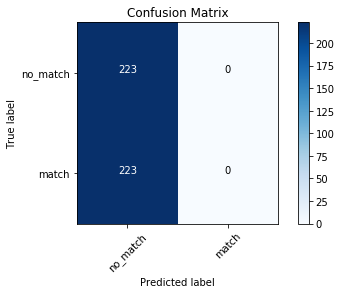

In [11]:

predictions = siamese_model.predict(x=test_dataset)
rounded_predictions = np.floor(predictions + 0.5).astype(int)

cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)
cm_plot_labels = ['no_match', 'match']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

print("Test Accuracy = ")
print(np.sum(test_labels == rounded_predictions.reshape(1, len(rounded_predictions)))/len(test_labels))

Confusion Matrix:
[[223   0]
 [223   0]]
False Acceptance Rate (FAR): 0.0
False Rejection Rate (FRR): 1.0
Equal Error Rate (EER): 0.0
Threshold at EER: 1.4936299


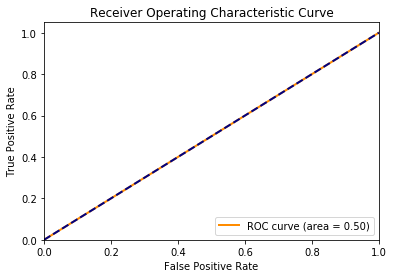

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate FAR and FRR
def calculate_far_frr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total_positive = np.sum(y_true)
    total_negative = len(y_true) - total_positive
    
    false_acceptance = cm[0, 1] / total_negative
    false_rejection = cm[1, 0] / total_positive
    
    return false_acceptance, false_rejection

# Calculate EER
def calculate_eer(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    eer_threshold = thresholds[np.argmin(np.abs(fpr - (1 - tpr)))]
    eer = fpr[np.argmin(np.abs(fpr - (1 - tpr)))]
    
    return eer, eer_threshold

# Plot ROC Curve and Calculate AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

# Calculate predictions, rounded predictions, and confusion matrix
predictions = siamese_model.predict(x=test_dataset)
rounded_predictions = np.floor(predictions + 0.5).astype(int)
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate FAR and FRR
far, frr = calculate_far_frr(test_labels, rounded_predictions)
print("False Acceptance Rate (FAR):", far)
print("False Rejection Rate (FRR):", frr)

# Calculate EER
eer, eer_threshold = calculate_eer(test_labels, predictions)
print("Equal Error Rate (EER):", eer)
print("Threshold at EER:", eer_threshold)

# Plot ROC Curve and Calculate AUC
plot_roc_auc(test_labels, predictions)


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

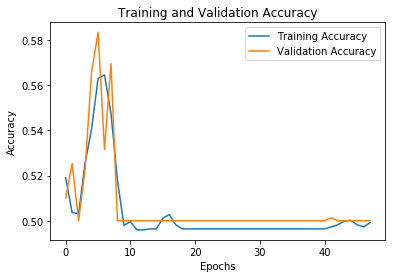

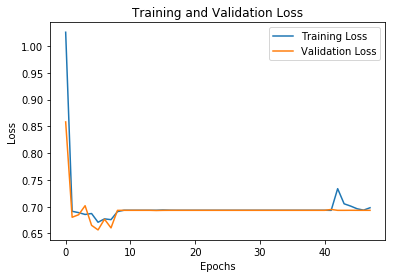

In [13]:
import matplotlib.pyplot as plt

def plot_curves(history):
    # Plot training and validation accuracy values
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming you have a `history` object containing training and validation metrics
plot_curves(history)


## Conclusion
This concludes your starter analysis! To go forward from here, click the blue "Fork Notebook" button at the top of this kernel. This will create a copy of the code and environment for you to edit. Delete, modify, and add code as you please. Happy Kaggling!